<a href="https://colab.research.google.com/github/jahaannadkarni1/load_forecasting_nyc_region/blob/main/Load_Forecasting_FbProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pandas
%pip install requests
%pip install numpy
%pip install time
%pip install matplotlib

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [ ]:
#To make API requests
import requests

#To store the data
import pandas as pd

#convert the response as a structured json
import json

#mathematical operations on lists
import numpy as np

#parse the datetimes we get from NOAA
from datetime import datetime

#for days in a month in a calendar
from calendar import monthrange

#introduce time lag in API call
import time

#load file from local system
## CHANGE DIRECTORY TO THE FILES DOWNLOADED
import os

#for visualizations
import matplotlib.pyplot as plt

#creating date on xticks
import matplotlib.dates as mdates

In [ ]:
#add the access token you got from NOAA
Token = 'UebjOugzDRohVGGzZQNqMGXKKSOtvcsy'

# New York City station
station_id = 'GHCND:USW00094728'

#data types
data_type = 'TMAX,TMIN,PRCP'

In [ ]:
import io
from google.colab import files
uploaded = files.upload()

Saving load_data(2015-2021).csv to load_data(2015-2021) (1).csv


In [ ]:
df = pd.read_csv(io.StringIO(uploaded['load_data(2015-2021).csv'].decode('utf-8')))

In [ ]:
df_load = pd.read_csv('load_data(2015-2021).csv',parse_dates=True)

In [ ]:
df_load['timestamp'] = pd.to_datetime(df_load[df_load.columns[0]])

In [ ]:
df_load.head()

,timestamp,load
0,2015-01-01 00:05:00,5362.3
1,2015-01-01 00:10:00,5344.5
2,2015-01-01 00:15:00,5340.1
3,2015-01-01 00:20:00,5315.8
4,2015-01-01 00:25:00,5322.9


In [ ]:
df_load.set_index('timestamp',inplace=True)

In [ ]:
df_load.head()

,load
timestamp,
2015-01-01 00:05:00,5362.3
2015-01-01 00:10:00,5344.5
2015-01-01 00:15:00,5340.1
2015-01-01 00:20:00,5315.8
2015-01-01 00:25:00,5322.9


In [ ]:
df_day_filter = df_load.resample('D').mean()

In [ ]:
df_day_filter.head()

,load
timestamp,
2015-01-01,5338.136934
2015-01-02,5671.767014
2015-01-03,5419.543836
2015-01-04,5191.942857
2015-01-05,5879.011644


In [ ]:
df_day_filter.reset_index(inplace=True)

Extracting Weather Data

In [ ]:
#initialize dates
dates= []
max_temps = []
min_temps = []
prcp = []

#make the api call
start_year = input('Start Year: ' )
end_year = input('End Year: ' )

for year in range(int(start_year),int(end_year)+1):
    for month in range(1,13):
        time.sleep(0.3)
        num_days = monthrange(year, month)[1]
        try:
            if len(str(month)) == 2:
                r = requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid={data_type}&limit=1000&stationid={station_id}&startdate={str(year)}-{str(month)}-01&enddate={str(year)}-{str(month)}-{str(num_days)}', headers={'token':Token})
            else:
                r = requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid={data_type}&limit=1000&stationid={station_id}&startdate={year}-0{str(month)}-01&enddate={str(year)}-0{str(month)}-{str(num_days)}', headers={'token':Token})

            #load the api response as json
            d = json.loads(r.text)

            #organize in a list
            date = [item['date'].split('T')[0] for item in d['results'] if item['datatype'] == 'PRCP']
            precip = [item['value'] for item in d['results'] if item['datatype'] == 'PRCP']
            tmax = [round(float(item['value'])/10.0*1.8,1) + 32 for item in d['results'] if item['datatype'] == 'TMAX']
            tmin = [round(float(item['value'])/10.0*1.8,1) + 32 for item in d['results'] if item['datatype'] == 'TMIN']

            #append in the list
            dates += date
            prcp += precip
            max_temps += tmax
            min_temps += tmin
        except:
            continue

Start Year: 2015
End Year: 2021


In [ ]:
df_weather = pd.DataFrame()

In [ ]:
df_weather['dates'] = dates
df_weather['max_temp'] = max_temps
df_weather['min_temp'] = min_temps
df_weather['precip'] = prcp

In [ ]:
df_weather['dates'] = pd.to_datetime(df_weather[df_weather.columns[0]])

In [ ]:
df_weather.head(5)

,dates,max_temp,min_temp,precip
0,2015-01-01,39.0,27.1,0
1,2015-01-02,42.1,35.1,0
2,2015-01-03,42.1,33.1,180
3,2015-01-04,55.9,41.0,76
4,2015-01-05,48.9,21.2,0


In [ ]:
df_weather['avg_temp'] = (df_weather['max_temp'] + df_weather['min_temp'])/2

In [ ]:
df_weather.head()

,dates,max_temp,min_temp,precip,avg_temp
0,2015-01-01,39.0,27.1,0,33.05
1,2015-01-02,42.1,35.1,0,38.60
2,2015-01-03,42.1,33.1,180,37.60
3,2015-01-04,55.9,41.0,76,48.45
4,2015-01-05,48.9,21.2,0,35.05


In [ ]:
df_weather.drop('precip',axis=1,inplace=True)

In [ ]:
df_weather = df_weather[:-3]

In [ ]:
df_weather.tail()

,dates,max_temp,min_temp,avg_temp
2306,2021-04-25,63.0,48.9,55.95
2307,2021-04-26,60.1,41.0,50.55
2308,2021-04-27,64.0,46.0,55.00
2309,2021-04-28,84.9,52.0,68.45
2310,2021-04-29,75.0,59.0,67.00


In [ ]:
df_day_filter.tail()

,timestamp,load
2306,2021-04-25,4305.064481
2307,2021-04-26,4736.331506
2308,2021-04-27,4725.120109
2309,2021-04-28,4848.565239
2310,2021-04-29,4370.812500


### **Fb Prophet Forecasting**

In [ ]:
df_prophet = df_day_filter.copy()

In [ ]:
df_prophet['avg_temp'] = df_weather['avg_temp']

In [ ]:
df_prophet.tail()

,timestamp,load,avg_temp
2306,2021-04-25,4305.064481,55.95
2307,2021-04-26,4736.331506,50.55
2308,2021-04-27,4725.120109,55.00
2309,2021-04-28,4848.565239,68.45
2310,2021-04-29,4370.812500,67.00


In [ ]:
df_prophet.columns = ['ds','y','avg_temp']

In [ ]:
df_prophet.head()

,ds,y,avg_temp
0,2015-01-01,5338.136934,33.05
1,2015-01-02,5671.767014,38.60
2,2015-01-03,5419.543836,37.60
3,2015-01-04,5191.942857,48.45
4,2015-01-05,5879.011644,35.05


In [ ]:
%pip install fbprophet

ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68


In [ ]:
type(df_prophet.ds[0])

pandas._libs.tslibs.timestamps.Timestamp

### Dependencies

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

### Model **1**

In [ ]:
model = Prophet(interval_width=0.95)
model.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=180)
future.tail()

,ds
2486,2021-10-22
2487,2021-10-23
2488,2021-10-24
2489,2021-10-25
2490,2021-10-26


In [ ]:
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2486,2021-10-22,4744.773832,3872.406245,5678.860809
2487,2021-10-23,4225.214190,3330.443656,5178.212952
2488,2021-10-24,4137.543240,3244.034067,5174.939964
2489,2021-10-25,4749.332909,3898.456578,5594.363371
2490,2021-10-26,4831.907209,3857.840489,5851.296853


<Figure size 6000x4000 with 0 Axes>

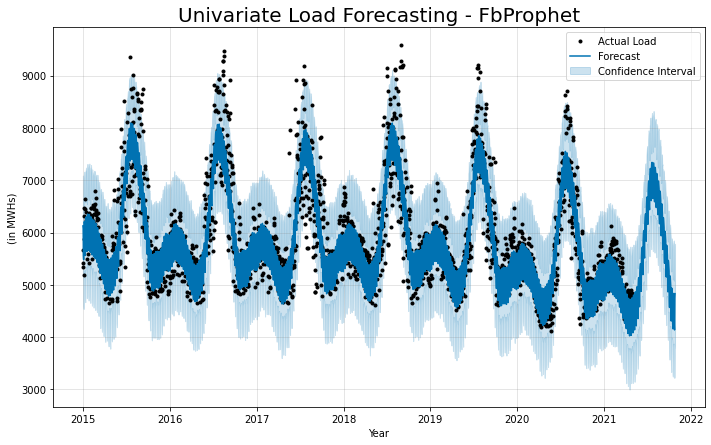

In [ ]:
plt.figure(dpi=1000)
fig1 =model.plot(forecast)

plt.xlabel('Year')
plt.ylabel('(in MWHs)')
plt.title('Univariate Load Forecasting - FbProphet', fontsize=20)
plt.legend(['Actual Load','Forecast','Confidence Interval'])
plt.show()

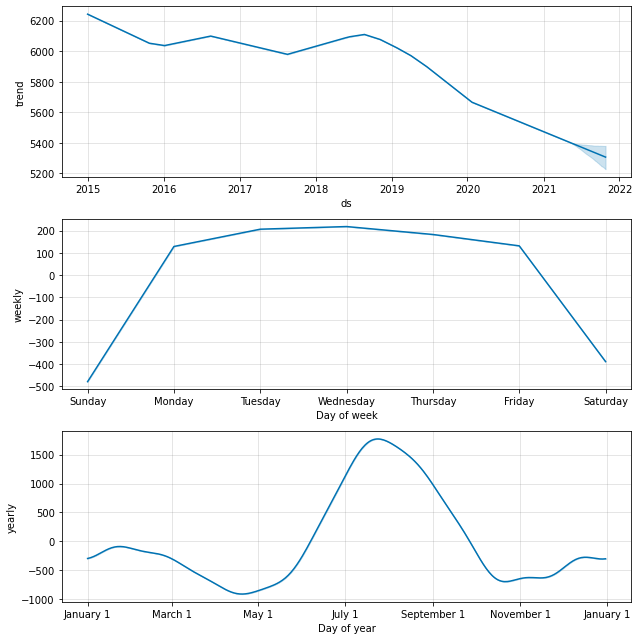

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
def getPerfomanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

In [ ]:
getPerfomanceMetrics(model).mean()

INFO:fbprophet:Making 40 forecasts with cutoffs between 2017-01-06 00:00:00 and 2020-04-29 00:00:00


horizon     201 days 00:00:00
mse                    419949
rmse                  647.563
mae                   483.079
mape                0.0820758
mdape               0.0642296
coverage             0.874472
dtype: object

In [ ]:
%pip install plotly

In [ ]:
import plotly.offline as pyoff
import plotly.graph_objs as go

### **Model** **2**

In [ ]:
model_r = Prophet()
# Adding the extra regressor
model_r.add_regressor('avg_temp')

In [ ]:
model_r.fit(df_prophet)
future = model.make_future_dataframe(periods=180)
future = future.merge(df_prophet, on='ds')
forecast3 = model_r.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast3.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,avg_temp,avg_temp_lower,avg_temp_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2306,2021-04-25,5400.862458,3409.740353,4668.909314,5400.862458,5400.862458,-1372.336432,-1372.336432,-1372.336432,1.017839,1.017839,1.017839,1.017839,1.017839,1.017839,-476.712446,-476.712446,-476.712446,-896.641825,-896.641825,-896.641825,0.0,0.0,0.0,4028.526026
2307,2021-04-26,5400.318956,4011.039133,5211.459571,5400.318956,5400.318956,-819.997683,-819.997683,-819.997683,-58.212849,-58.212849,-58.212849,-58.212849,-58.212849,-58.212849,131.012854,131.012854,131.012854,-892.797688,-892.797688,-892.797688,0.0,0.0,0.0,4580.321272
2308,2021-04-27,5399.775454,4081.218627,5275.638794,5399.775454,5399.775454,-695.181077,-695.181077,-695.181077,-9.402375,-9.402375,-9.402375,-9.402375,-9.402375,-9.402375,202.607071,202.607071,202.607071,-888.385773,-888.385773,-888.385773,0.0,0.0,0.0,4704.594377
2309,2021-04-28,5399.231952,4280.409463,5485.495029,5399.231952,5399.231952,-534.392120,-534.392120,-534.392120,138.125914,138.125914,138.125914,138.125914,138.125914,138.125914,211.021139,211.021139,211.021139,-883.539174,-883.539174,-883.539174,0.0,0.0,0.0,4864.839832
2310,2021-04-29,5398.688451,4135.946975,5429.546160,5398.688451,5398.688451,-577.208809,-577.208809,-577.208809,122.221378,122.221378,122.221378,122.221378,122.221378,122.221378,178.953541,178.953541,178.953541,-878.383728,-878.383728,-878.383728,0.0,0.0,0.0,4821.479642


In [ ]:
future.tail()

,ds,y,avg_temp
2306,2021-04-25,4305.064481,55.95
2307,2021-04-26,4736.331506,50.55
2308,2021-04-27,4725.120109,55.00
2309,2021-04-28,4848.565239,68.45
2310,2021-04-29,4370.812500,67.00


In [ ]:
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=df_prophet['ds'], y=df_prophet['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast3['ds'], y=forecast3['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast3['ds'], y=forecast3['avg_temp'], name='Average Temp',))
fig.show()

In [ ]:
from fbprophet.diagnostics import performance_metrics

In [ ]:
getPerfomanceMetrics(model).mean()

INFO:fbprophet:Making 40 forecasts with cutoffs between 2017-01-06 00:00:00 and 2020-04-29 00:00:00


horizon     201 days 00:00:00
mse                    408189
rmse                  638.554
mae                   490.001
mape                0.0836424
mdape               0.0684574
coverage             0.728811
dtype: object

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [ ]:
def getPerfomanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

# Plotly

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model,forecast)